In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

is_kaggle = "KAGGLE_WORKING_DIR" in os.environ or "/kaggle" in os.getcwd()
print("Running on Kaggle:", is_kaggle)

if is_kaggle:
    data_path = "/kaggle/input/titanic/"
else:
    data_path = os.getcwd() + "/"

Running on Kaggle: False


In [2]:
import torch
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

Based on fast.ai chapter 5 we'll now iterate on the numpy-titanic notebook by using pytorch and applying some best practices from that chapter

## Prepare Data set

In [3]:
df = pd.read_csv(data_path + "train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Handling na values
For linear regression to work we need numerical values, n/a values are not numerical so we should check if our data set contain them.

In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We should avoid removing columns or rows. Even the absence of data can sometimes indicate a pattern.

There are many ways to substitute na_values, the easiest of which is to replace na values with the mode value (the most commonly occuring value). This is a good starting point as usually the method of substituion doesn't have a large impact on our results so the mode is good to get an MVP up and running we can iterate on.

In [5]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [6]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [7]:
def substitue_na_with_modes(df: pd.DataFrame) -> pd.DataFrame:
    modes = df.mode().iloc[0]
    return df.fillna(modes)

### Converting Category Data to Binary Categorical Values


We can get view our non-numeric or numberic data using the describe function.


In [8]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


Sex and Embarked only have 2, and 3 unique values respectively. It's safe to say these are categorical values.

We should also check if any of our numbers are categorical

In [9]:
df.describe(include=[np.number])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see from its quarile values that PClass is likely also categorical despite being numeric as its only values are 1, 2 or 3. We can confirm this by looking at the [data dictionary](https://www.kaggle.com/competitions/titanic/data) for the kaggle competition and by via pandas.


In [10]:
df.Pclass.unique()

array([3, 1, 2])


Sex, the Passenger class and Embarking city are not measurable attributes so we should convert them to Boolean numbers that can be used as co-efficients. In the previous notebook we did this manually however this pandas can do this for us using `Dataframe.get_dummies()`

In [11]:
categorical_feature_names = ['Sex', 'Embarked', 'Pclass']
df = pd.get_dummies(df, columns=categorical_feature_names, dtype=int)
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [12]:
dummy_column_names = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q',
       'Embarked_S']
df[dummy_column_names].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


In [13]:
def convert_categories_to_binary_values(df: pd.DataFrame) -> pd.DataFrame:
    categorical_feature_names = ['Sex', 'Embarked', 'Pclass']
    return pd.get_dummies(df, columns=categorical_feature_names, dtype=int)

### Handling long-tail numerical data

<Axes: >

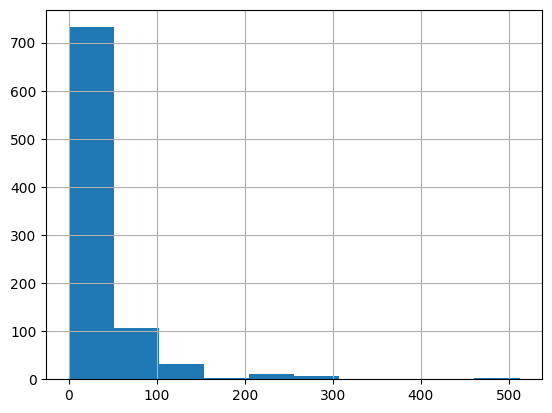

In [14]:
import matplotlib
df.Fare.hist()

The `Fare` column has lots of small values with the occasional very large value. Uniform normalization using the max value isn't ideal when we're dealing with lots of small values with occasional very large values as the variation between the lower numbers will be lost. To normalize the values we can use a log function (log10 here) to bring the numbers down to reasonable ranges. We must use `log10(x+1)` to avoid 0 values as `log10(0)` would give us infinity.

<Axes: >

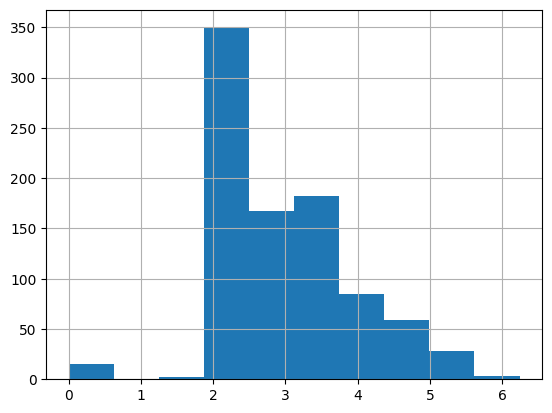

In [15]:
import math
df['LogFare'] = np.log(df['Fare'] + 1)
df.LogFare.hist()

## Linear Regression

### Pytorch Tensors
For our gradient descent we'll be using Pytorch rather than numpy for this workbook as it will do a lot of the heavy lifting for us. Alongside Tensorflow pytorch is the most commonly used framework for machine learning.

We'll start by creating Tensors for our target values (known survival status) and features (our numerical data).

In [16]:
from torch import tensor
target_tensor = tensor(df.Survived)
target_tensor

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 

In [17]:
feature_names = ['Age', 'SibSp', 'Parch', 'LogFare'] + dummy_column_names
feature_df = df[feature_names]
feature_df

,Age,SibSp,Parch,LogFare,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,2.110213,1,0,0,0,1,0,0,1
1,38.0,1,0,4.280593,0,1,1,0,0,1,0,0
2,26.0,0,0,2.188856,0,1,0,0,1,0,0,1
3,35.0,1,0,3.990834,0,1,1,0,0,0,0,1
4,35.0,0,0,2.202765,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,2.639057,1,0,0,1,0,0,0,1
887,19.0,0,0,3.433987,0,1,1,0,0,0,0,1
888,24.0,1,2,3.196630,0,1,0,0,1,0,0,1
889,26.0,0,0,3.433987,1,0,1,0,0,1,0,0


In [18]:
features = feature_df.values
feature_tensor = tensor(features, dtype=torch.float)
feature_tensor

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

### Normalization
Once all our features are numerical we need to ensure they're somewhat uniform. For Linear regression and many other ML methods having some features be much larger than others will disrupt the process. Rather than do this manually we can have Pytorch do this for us.

In [19]:
max_values, max_indices = feature_tensor.max(dim=0)
max_values

tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])

In [20]:
feature_tensor = feature_tensor / max_values
feature_tensor

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

#### Broadcasting
`feature_tensor / max_values` is an example of [broadcasting](https://pytorch.org/docs/stable/notes/broadcasting.html). 
`max_values` is a one dimensional vector with shape (12). `feature_tensor` is a 2 dimensional matrix with shape (892,12). Because `max_values` is the same size as one of `feature_tensor`'s it will be applied to all 891 rows of `feature_tensor`

Broadcasting is useful for large datasets. The calculations are optimized and run on a GPU when available.

### Prepare initial linear co-efficient values
For linear regression we'd like a one dimensional vector of coefficients equal to our number of rows. Unlike in previous examples we don't need a constant as our dummy variables effectively act as a constant.

In [21]:
torch.manual_seed(442)
feature_count = feature_tensor.shape[1]
coefficients = torch.rand(feature_count) - 0.5
coefficients

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

Generally we don't want to set a manual seed so we can be aware of how stable our data is or isn't. However for the sake of this lesson I'd like to check I'm getting consistent results with the lesson plan.

### Create Predictions
We calculate the linear function of our parameters by multiplied them against our random Coefficients then summing each row of weighted values up to create a prediction for each passenger
Pytorch's broadcasting can once again be used here to simplify things considerably. We'll print it out to check there aren't any weighted values that are significantly oversized.

In [22]:
weighted_values = feature_tensor * coefficients
weighted_values[:4]

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625]])

In [23]:
predictions = weighted_values.sum(dim=1)
predictions[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

### Calculate loss
Our loss here is the average difference between our prediction value and whether the passegner survived or not (1 or 0).

In [24]:
loss = torch.abs(predictions - target_tensor).mean()
loss

tensor(0.5382)

In [25]:
def create_predictions(features: torch.Tensor, coefficients: torch.Tensor) -> torch.Tensor:
    return (coefficients * features).sum(dim=1)

In [26]:
def calculate_loss(features: torch.Tensor, coefficients: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    predictions = create_predictions(features, coefficients=coefficients)
    return torch.abs(predictions - targets).mean()

### Doing a single Gradient Descent step
Now we want to optimize our loss with gradient descent. This too will be significantly easier using Pytorch as it will calculate the gradient for us.

We must tell pytorch to store the results of each coefficient calculation so we can get the gradients from it later.

In [27]:
coefficients.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [28]:
loss = calculate_loss(feature_tensor, coefficients=coefficients, targets=target_tensor)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

The loss is in a tensor where can ask Pytorch to calculate the gradient by calling `backward()`

In [29]:
loss.backward()
coefficients.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

Here we perform one gradient descent step


In [30]:
loss = calculate_loss(feature_tensor, coefficients=coefficients, targets=target_tensor)
loss.backward
with torch.no_grad():
    assert coefficients.grad is not None
    coefficients.sub_(coefficients.grad * 0.1)
    coefficients.grad.zero_()
    print(calculate_loss(feature_tensor, coefficients=coefficients, targets=target_tensor))

tensor(0.5197)


A few points:
1. `torch.no_grad()` is required to ensure the parameter update step is peformed without tracking gradients. We want to track gradients for the forward and backward steps but not when directly modifying the parameters
2. `coefficients.sub_(coefficients.grad * 0.1)` reduces the coefficients by their gradient to the loss. More significant features will be reduced more. 
3. Both `sub_` and `zero_` operations are done in place for memory efficiency and to preserve the tensors memory graph (this is also ensured by `torch.no_grad()` although it's good practice when working with tensors).
4. `coefficients.grad.zero_()` sets our gradients to zero. This is necessary as if we were to do another backpass the new gradients would be added to the old ones.

### Creating a validation set


Before we begin training we need a validation set to compare our training data against.

I've deviated from the [fast.ai kaggle workbook](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch) as they split their validation set using the fastai library to keep things consistent for their next chapter. I'm interested in primarily learning Pytorch so I'm going to split the dataset without the fastai library. However so I can check if my results match fast.ai's I'm going to include their splitter here it will be used if `use_fastai_splitter` is set to `True` so I can check my results are consistent with the fast.ai tutorials.

In [31]:
from random import Random
from numpy import int64
from fastai.data.transforms import RandomSplitter
from typing import Tuple, List, cast
from fastcore.foundation import L
from torch import Tensor

def split_data_with_fastai(df: pd.DataFrame) -> Tuple[Tensor,Tensor]:
    train_indices, validation_indices = RandomSplitter(seed=42)(df)
    return torch.tensor(train_indices, dtype=torch.int64), torch.tensor(validation_indices, dtype=torch.int64)

First we'll split our data

In [32]:
use_fastai_splitter = True
total_passengers = feature_tensor.size(0)
training_set_size = int(total_passengers * 0.8)

if use_fastai_splitter:
    train_indices, validation_indices = split_data_with_fastai(df)
else:
    randomized_indices = torch.randperm(total_passengers)
    train_indices = randomized_indices[:training_set_size]
    validation_indices = randomized_indices[training_set_size:]

training_features = feature_tensor[train_indices]
validation_features = feature_tensor[validation_indices]
training_targets = target_tensor[train_indices]
validation_targets = target_tensor[validation_indices]
len(training_features), len(validation_features)

(713, 178)

This note book doesn't use Pytorch's `Dataset`s. We'd likely use these in a real project although for this example we're keeping things a bit barer than normal so we can see the process.

We'll add what we've done so far in to functions to make things easier to read and re-usable.

In [33]:
def update_coefficients(coefficients, learning_rate):
    coefficients.sub_(coefficients.grad * learning_rate)
    coefficients.grad.zero_()

In [34]:
def one_epoch(coefficients, learning_rate):
    loss = calculate_loss(training_features, coefficients, training_targets)
    loss.backward()
    with torch.no_grad():
        update_coefficients(coefficients, learning_rate=learning_rate)
        
    print(f"{loss:.3f}", end="; ")

In [35]:
def generate_coefficients(features: torch.Tensor) -> torch.Tensor:
    coefficient_count = features.shape[1]
    coefficients = torch.rand(coefficient_count) - 0.5
    coefficients.requires_grad_()
    return coefficients

Now to train the model

In [36]:
def train_model(epoch_count=30, learning_rate=0.1):
    coefficients = generate_coefficients(training_features)
    for i in range(epoch_count):
        one_epoch(coefficients, learning_rate=learning_rate)
    return coefficients

In [37]:
coefficients = train_model(epoch_count=18, learning_rate=0.2)
coefficients

0.550; 0.494; 0.446; 0.400; 0.385; 0.392; 0.348; 0.351; 0.365; 0.327; 0.345; 0.310; 0.326; 0.292; 0.308; 0.280; 0.323; 0.269; 

tensor([ 0.0114, -0.1277, -0.0490,  0.2052,  0.0136,  0.7174,  0.0278, -0.1602, -0.1642,  0.1394,  0.3767,  0.2155], requires_grad=True)

We can see below that our models has optimized our weights to reduce our loss. From this we can see that the model believes

In [38]:
def show_coeffs(): 
    coeff_array = [coeff.item() for coeff in coefficients]
    coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeff_array})
    display(coeff_df)
show_coeffs()

,Feature,Coefficient
0,Age,0.011448
1,SibSp,-0.127748
2,Parch,-0.049038
3,LogFare,0.205193
4,Sex_male,0.013623
5,Sex_female,0.717442
6,Pclass_1,0.027782
7,Pclass_2,-0.160171
8,Pclass_3,-0.164208
9,Embarked_C,0.139427


### Measuring accuracy

To view our accuracy we'll now use our validation set. We'll create predictions using our newly trained coefficients and see how accurate they are.

In [39]:
predictions = create_predictions(validation_features, coefficients=coefficients)
predictions[:10]

tensor([1.0226, 0.3008, 0.0616, 0.2132, 0.1593, 0.1594, 0.7728, 0.8635, 0.0960, 0.7756], grad_fn=<SliceBackward0>)

If our predictions is >0.5 and the passegner surivied we're correct. If the passenger died we want a prediction < 0.5. 0 = died, 1 = survived. This code merely rounds our predictions to whichever of these values is closest

In [40]:
results = validation_targets.bool() == (predictions>0.5)
results.float().mean()

tensor(0.7865)

We're 79% accurate which is pretty good going.

In [41]:
from torch import Tensor


def calculate_accuracy(coefficients, features: torch.Tensor) -> Tensor:
    predictions = create_predictions(features, coefficients=coefficients)
    results = validation_targets.bool() == (predictions>0.5)
    return results.float().mean()

### Sigmoid
When creating predictions that are between 0 and 1 we can increase our accuracy by using the sigmoid function which moves all our values between 0 and 1 and larger negative or positives values will respectively asymptotically converge towards 0 or 1.

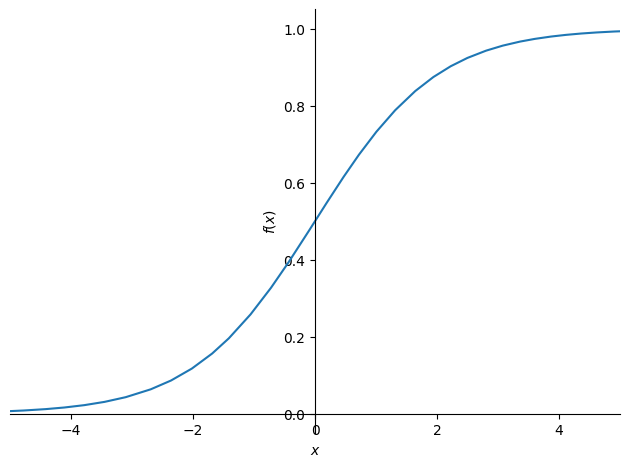

In [42]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5))

In [43]:
def create_predictions(features: torch.Tensor, coefficients: torch.Tensor) -> torch.Tensor:
    summed_weighted_values = (coefficients * features).sum(dim=1)
    return torch.sigmoid(summed_weighted_values)


Constricting the range of our predictions within the range of what they can realistically be makes them much easier to optimize. When this is applied to every prediction each epoch should minimize our loss more effectivelyby by eliminating values that are outside the range of what our predictions can realistically be.

This in turn allows us to substantially increase the learning rate as our loss won't be as high or fluctuate as wildly.

In [44]:
coefficients = train_model(learning_rate=100)
calculate_accuracy(coefficients, features=validation_features)

0.451; 0.324; 0.299; 0.209; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

tensor(0.8258)

83% a sharp improvement!

## Prepare Submission CSV

### Using a Test set
Before submitting to Kaggle we'll want to test the effectiveness of our data against our test set. 
#### Why not use the Validation set?
This may seem similar to how we used our validation set but there's an important difference. A validation set is used to give us an unbiased evaluation of our model's performance. Unlike a training set which is biased as we're training our model on it. As we develop our model the validation set will indirectly become biased as we iterate on our model to improve the validation sets accuracy. The test set is only ever used once we have finished developing our model so it gives us an accurate assessment of how our model behaves on completely unseen data.

- Training set - Model bias
- Validation Set - Developer bias
- Test set - No bias

### Clean Test Data

In [45]:
test_df = pd.read_csv(data_path + 'test.csv')
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We can use the same steps we took for cleaning the training data on our test data. However it's always worth checking if there are any additional na values. Here there's an na value for Fare that needs resolving.

In [46]:
from cgi import test


test_df.Fare.fillna(0, inplace=True)
test_df = substitue_na_with_modes(test_df)
test_df = convert_categories_to_binary_values(test_df)
test_df["LogFare"] = np.log(test_df['Fare'] + 1)
test_df.isna().sum()


PassengerId    0
Name           0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Sex_female     0
Sex_male       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Pclass_1       0
Pclass_2       0
Pclass_3       0
LogFare        0
dtype: int64

In [47]:
test_df[feature_names][:5]

,Age,SibSp,Parch,LogFare,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0,0,2.178064,1,0,0,0,1,0,1,0
1,47.0,1,0,2.079442,0,1,0,0,1,0,0,1
2,62.0,0,0,2.369075,1,0,0,1,0,0,1,0
3,27.0,0,0,2.268252,1,0,0,0,1,0,0,1
4,22.0,1,1,2.586824,0,1,0,0,1,0,0,1


In [48]:
test_features = tensor(test_df[feature_names].values, dtype=torch.float)
test_features = test_features / max_values
test_features[:3]

tensor([[0.4313, 0.0000, 0.0000, 0.3490, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.5875, 0.1250, 0.0000, 0.3332, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.7750, 0.0000, 0.0000, 0.3796, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000]])

In [49]:
feature_tensor

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

In [50]:
coefficients

tensor([ -0.7410,  -1.1686,  -0.5568,   0.5259, -10.4339,   8.4665,   3.0045,   1.5414,  -6.7864,   1.8826,   2.2974,  -4.6379],
       requires_grad=True)

### Create test predictions

In [51]:
with torch.no_grad():
    test_predictions = create_predictions(test_features, coefficients=coefficients)
test_predictions = (test_predictions > 0.5).int()
test_predictions

tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 

### Create Kaggle submission
We can view the sample submission kaggle has given us to see how to format this.

In [52]:
sample_df = pd.read_csv(data_path + "gender_submission.csv")
sample_df[:3]

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [53]:
submission_df = pd.DataFrame({ "PassengerId": test_df["PassengerId"], "Survived": test_predictions })
submission = submission_df.to_csv("submission.csv",index=False)
!head submission.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


## Neural Nets
The calculation above was a linear regression as we only use one set of parameters in the form of our features which we immedietely derived the output from. This effectively gave us a single layer with one neuron.

Here we'll employ two additional concepts to improve the resolution of our calculations accuracy. We will create a single hidden layer with multiple neurons, apply a RELU (Rectified Linear Unit) function and add them together to give us a loss. A RELU function is non-linear and simply replaces every negative number with a 0.

### Create Matrix of Coefficients

Prior to now we were using a single neuron consisting of a single layer. We're now going to add additional neurons by generating more than one set of coefficients

Our first layer will take our inputs/features and create 20 outputs from 20 different sets of coefficients.

In [54]:
hidden_layer_neuron_count = 20
layer1 = torch.rand(feature_count, hidden_layer_neuron_count) - 0.5
layer1.shape

torch.Size([12, 20])

When we've more than one neuron we need to adjust the values of each neuron proportionally so we end up with a similar magnitude.

In [55]:
layer1 = layer1 / hidden_layer_neuron_count
layer1[:3]

tensor([[ 0.0239, -0.0101, -0.0043,  0.0095, -0.0041, -0.0049, -0.0207,  0.0067, -0.0151,  0.0009,  0.0244, -0.0077, -0.0079,  0.0151,
         -0.0092, -0.0021,  0.0233, -0.0102, -0.0179, -0.0140],
        [-0.0069, -0.0119, -0.0130,  0.0101,  0.0042, -0.0080, -0.0194, -0.0079, -0.0106, -0.0081, -0.0226,  0.0054, -0.0184, -0.0195,
         -0.0204,  0.0104, -0.0151, -0.0103,  0.0196,  0.0133],
        [ 0.0143, -0.0237, -0.0179, -0.0094,  0.0207,  0.0026, -0.0187,  0.0002, -0.0194, -0.0055, -0.0069,  0.0216,  0.0077, -0.0044,
          0.0042, -0.0072,  0.0098,  0.0099,  0.0067, -0.0097]])

### Creating an output layer
The 2nd layer is our output layer which will produce one output predicting the passengers survival. As we're using neurons from a hidden layer as our input and not our features which included dummy values we now need to include a constant (also known as a bias). This 2nd layer consists of one neuron

In [56]:
layer2 = torch.rand(hidden_layer_neuron_count, 1) - 0.3
constant = torch.rand(1)[0]
layer2.shape

torch.Size([20, 1])

In [57]:
def generate_coefficients(features: torch.Tensor, hidden_layer_neuron_count: int=20):
    feature_count = features.shape[1]
    layer1 = (torch.rand(feature_count, hidden_layer_neuron_count) - 0.5) / feature_count
    layer2 = torch.rand(hidden_layer_neuron_count, 1) - 0.3
    constant = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), constant.requires_grad_()

### Convert targets to column vectors
Lastly we need to add an additional dimension to our targets so matrix multiplications will work correctly on them.  We need to be very careful to remember to do this as not doing so won't return an error but will give us incorrect results as the Pytorch will attempt to broadcast the mishaped target tensor.

In [58]:
training_targets = training_targets[:,None]
validation_targets = validation_targets[:,None]

### Matrix Multiplication
Now that we have more than one neuron (more than one row of parameters/coefficients) we need to switch from using pytorch's broadcasting to matrix multiplication so that every row of parameters is multiplied with our features. It's also worth noting using PyTorch's matrix multiplication `@` is very efficient as it's been highly optimized both algorithmically and for operating on multi-core GPUs. You'll see us using this later when we create the neural net.

```python
torch.sigmoid(coefficients @ features)
```

### Updating multiple coefficients
We also need to loop through our coefficients now we have more than one layer. We simpy add a loop to our existing function.

In [59]:
def update_coefficients(coefficients, learning_rate):
    for layer in coefficients:
        layer.sub_(layer.grad * learning_rate)
        layer.grad.zero_()

### Creating the Neural net
Our plan for this neural net is to have two layers.

12 Features -> |20 neuron hidden layer| --(Relu)-> |1 neuron output layer| --(Sigmoid)-> 1 Survival prediction

In [66]:
print(df.Name[788])
print(str(feature_tensor[0].shape) + " --> " + str(layer1.shape) + " --> " + str(layer2.shape) + " --> " + str(predictions[0].item()))

Dean, Master. Bertram Vere
torch.Size([12]) --> torch.Size([12, 20]) --> torch.Size([20, 1]) --> 1.0225906372070312


If you're curious [Bertram](https://titanic.fandom.com/wiki/Bertram_Vere_Dean) did indeed survive and lived until 1992.


The RELU is needed as adding together two linear functions just gives us another linear function which doesn't give us any more resolution for our calculation. Combining each linear layer with a non-linear RELU allows us to keep each linear functions utility increasing our algortihms accuracy.

In [67]:
import torch.nn.functional as F

def create_predictions(features: torch.Tensor, coefficients: tuple[Tensor, Tensor, Tensor]) -> torch.Tensor:
    layer1_parameters, layer2_parameters, constant_parameter = coefficients
    layer1_output = F.relu(features @ layer1_parameters)
    layer2_output = torch.sigmoid(layer1_output @ layer2_parameters + constant_parameter)
    return layer2_output

In [68]:
coefficients = train_model(learning_rate=20)

0.537; 0.437; 0.298; 0.245; 0.215; 0.215; 0.215; 0.215; 0.215; 0.215; 0.214; 0.214; 0.213; 0.206; 0.204; 0.208; 0.195; 0.194; 0.194; 0.194; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 

In [69]:
calculate_accuracy(coefficients, features=validation_features)

tensor(0.8258)

### Linear Regression vs Neural Net
Our 82.58% accuracy is by (I compared my results against fast.ai's where the same thing happeneed to them) coincidence the same result as we got from the linear model. Usually a neural net will have improved performance against a linear model. However for relatively small simple datasets such as the titanic dataset linear regression will usually do just fine and less complexity isn't neeeded.